In [2]:
%load_ext autoreload
%autoreload 2
from logistic import LogisticRegression, GradientDescentOptimizer

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch


In [4]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

In [5]:
LR = LogisticRegression()
opt = GradientDescentOptimizer()
loss_arr = []
for _ in range(100):
    # add other stuff to e.g. keep track of the loss over time.
    loss = opt.loss(X, y)
    loss_arr.append(loss)
    opt.step(X, y, alpha = 0.1, beta = 0.9)

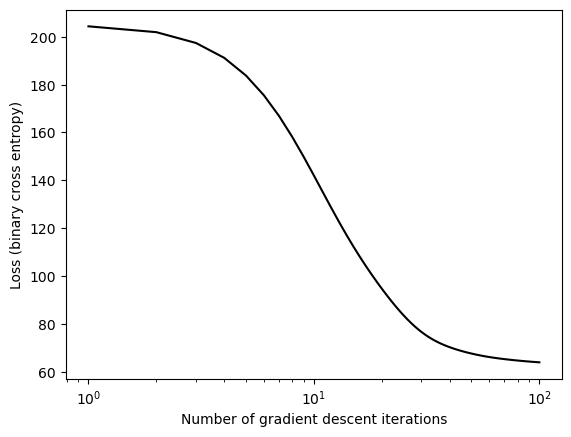

In [6]:
plt.plot(torch.arange(1, len(loss_arr)+1), loss_arr, color = "black")
plt.semilogx()
labs = plt.gca().set(xlabel = "Number of gradient descent iterations", ylabel = "Loss (binary cross entropy)")

### Implement Vanilla Gradient Descent

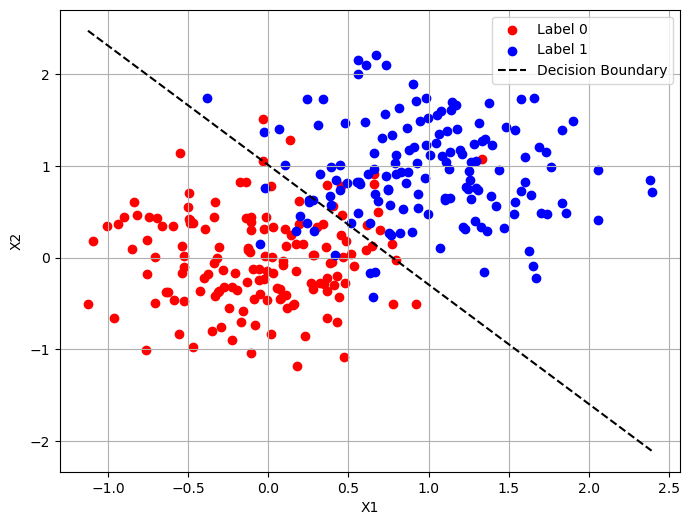

In [7]:
def plot_data_and_w(X, y, w):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='red', label='Label 0')
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='blue', label='Label 1')

    # Decision boundary: w0*x + w1*y + w2 = 0
    x_vals = torch.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    if w[1] != 0:
        y_vals = -(w[0] * x_vals + w[2]) / w[1]
        plt.plot(x_vals, y_vals, 'k--', label='Decision Boundary')

    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_data_and_w(X, y, opt.w)